# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

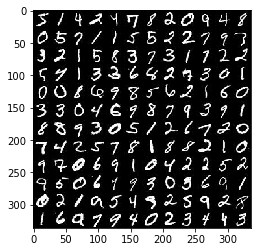

In [2]:
show_n_images = 152

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

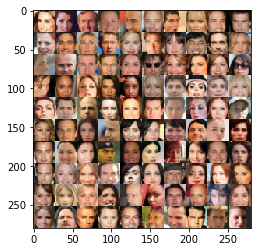

In [3]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        flat = tf.reshape(relu1, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # https://github.com/raoanonymous/udacity_dlnd/blob/master/face_generation/dlnd_face_generation.ipynb
    # https://discussions.udacity.com/t/need-help-for-mnist-training/413800/6
    
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    out_channel_dim = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, 3, reuse=True, training=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                    plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.7844


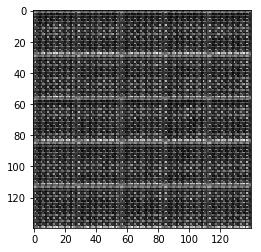

Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.7616
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.6802


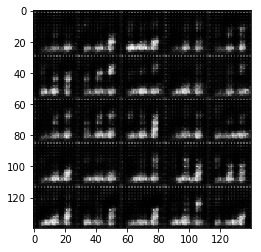

Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.6632
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.6658
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.6785


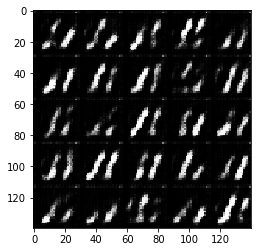

Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.7051
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.6870
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7091


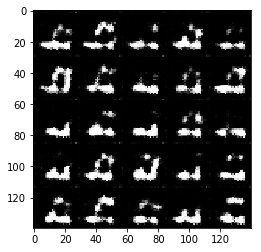

Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.6913


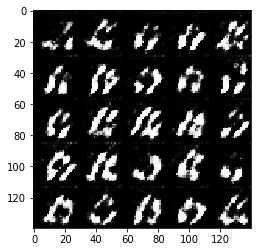

Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.6895


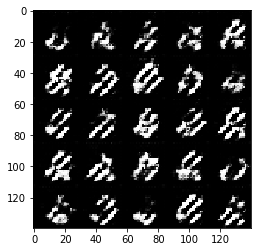

Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6754
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.7131


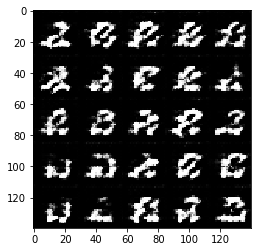

Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.6862
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.7022


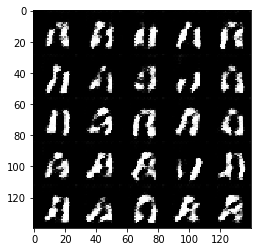

Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.6988


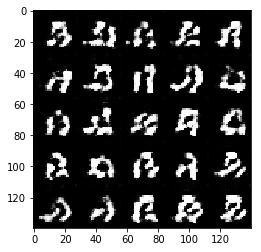

Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.6635


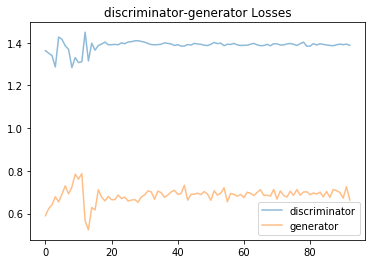

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8841


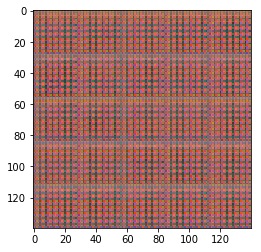

Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6510


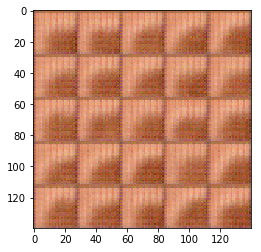

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.5994


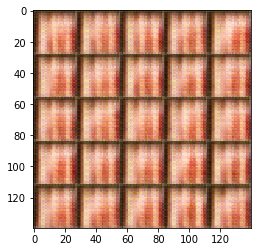

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6474


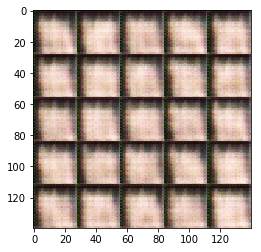

Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6430


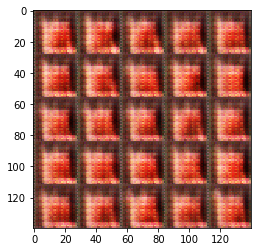

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7320


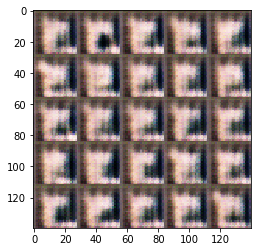

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7115


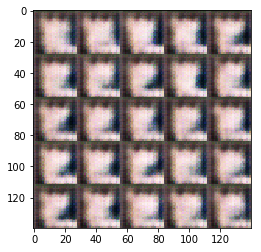

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6669


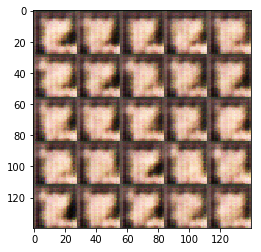

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6467


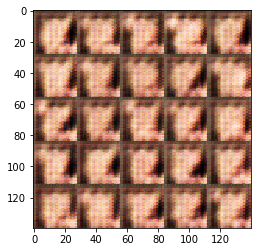

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6595


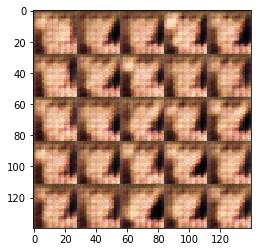

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6805


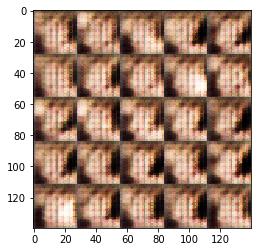

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7040


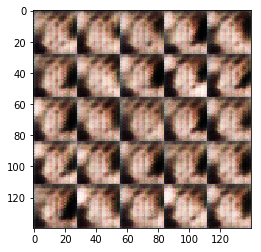

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6709


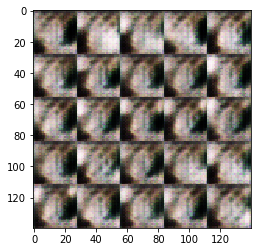

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7151


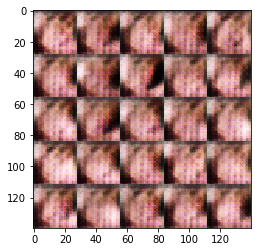

Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6947


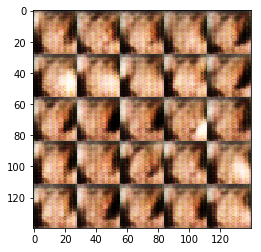

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7120


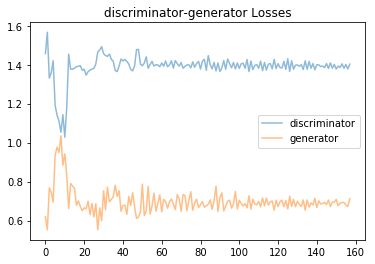

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.